# **Feature Engineering Part 2: Word Embeddings**

In this example, I use the *King James Bible* from the Gutenberg corpus as a large sample that I can use to train a word-embedding model. Training word-embedding models is computationally expensive and time-consuming. So, I'm going to use a GPU instance from Google Colab.

## **1) Getting Set up**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.corpus import gutenberg

from string import punctuation
from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import re

wpt = nltk.WordPunctTokenizer()                                               # assign wordpunctokenizer to wpt
stop_words = nltk.corpus.stopwords.words('english')                           # bring in stopwords from nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
url = "https://gutenberg.org/files/10/10-h/10-h.htm"
response = request.urlopen(url)

raw = response.read().decode('utf-8-sig')
raw
print(raw.find("1:1"), ":", raw.rfind("END OF THE PROJECT GUTENBERG"))

10282 : 4634877


In [ ]:
raw = raw[10282:4634877]

> #### **A) Define Normalize Document Function**



In [ ]:
def normalize_document(doc):
    soup = BeautifulSoup(doc, 'html.parser')
    [s.extract() for s in soup(['iframe', 'script'])]
    doc = soup.get_text()
    doc = re.sub(r'[^a-zA-Z\.\s]', '', doc)
    doc = doc.lower()
    doc = doc.strip()
    tokens = wpt.tokenize(doc)                                                   # tokenize document
    filtered_tokens = [token for token in tokens if token not in stop_words]     # filter out stopwords from document
    doc = ' '.join(filtered_tokens)                                              # re-create doucment from filtered tokens
    return doc

> #### **B) Apply Normalization Function, tokenize the sentences, then remove punctation**

In [ ]:
norm_bible = normalize_document(raw)

In [ ]:
punkt_st = nltk.tokenize.PunktSentenceTokenizer()
norm_sents = punkt_st.tokenize(norm_bible)
def remove_punc(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:
        if ele in punc:
            string = string.replace(ele, " ")
    return string

norm_sents = [remove_punc(i) for i in norm_sents]
norm_sents[0:5]

['beginning god created heaven earth  ',
 'earth without form void darkness upon face deep  ',
 'spirit god moved upon face waters  ',
 'god said let light light  ',
 'god saw light good god divided light darkness  ']

## **2) Training a Word2Vec Model for Word Embeddings**

### Continuous Bag of Words (CBOW) Model

Implementing this method from scratch involves five primary steps:
1. Building the corpus vocabulary
2. Building a CBOW (context, target) generator
3. Building the CBOW model archicture
4. Training the model
5. Getting the word embeddings!


> #### **A) Building corpus vocab**
> The first step in this process is separating out the text into the vocabulary, which consists of all the unique words in the text. I bring in some libraries that are often used in NLP and machine learning, including `tensorflow`.

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_sents)                                                        # tokenize norm_bible text
word2id = tokenizer.word_index                                                            # store word index numbers

In [ ]:
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}                                               # create dictionary of words with their index numbers

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_sents]      # create list of lists of word sequences for each sentence in norm_bible, represented by word index number

**Let's take a step back and see what each of these variables contain...**

In [ ]:
vocab_size = len(word2id)
embed_size = 100
window_size = 2                                                                           # context window size, how many words surrounding target word are taken into account

print('Vocab Size:', vocab_size)
print('\nVocab Sample:', list(word2id.items())[:10])

Vocab Size: 12568

Vocab Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('said', 7), ('ye', 8), ('thee', 9), ('upon', 10)]


**What does it mean to have a window size of 2?**

Two words before the target word and two words after. (2 to left and two to the right)

> #### **B) Building CBOW (Context, Target) Generator**

In [ ]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2                                                                    # context is 2 words to either side of the target word
    for words in corpus:                                                                              # for each word in corpus...
        sentence_length = len(words)                                                                  # set the sentence length to the length of words
        for index, word in enumerate(words):                                                          # assign numeric value for each word, use as index
            context_words = []                                                                        # create list for context_words
            label_word = []                                                                           # create list of label words
            start = index - window_size                                                               # set the start to be 2 left of the index (window)
            end = index + window_size + 1                                                             # set the end to be the 3 right of the index

            context_words.append([words[i]                                                            # fill in the context words for each word in the corpus between start, end
                                 for i in range(start, end)
                                 if 0 <= i < sentence_length
                                 and i != index])
            label_word.append(word)                                                                   # add word label to each word

            x = pad_sequences(context_words, maxlen = context_length)                                 # save context words to x
            y = np_utils.to_categorical(label_word, vocab_size)                                       # save associated target word to y
            yield(x, y)

**Now let's apply the context word pair generator to a sample of the first 10 words from the corpus to see a) what it does and b) that it worked.**

In [ ]:
i = 0
for x, y in generate_context_word_pairs(corpus = wids, window_size=window_size, vocab_size=vocab_size):                   # set corpus to word sequences from norm_bible
    if 0 not in x[0]:                                                                                                     # window size is 2, vocab_size is vocab_size
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])             # start at word 0, end at word 9
        if i == 9:
            break
        i += 1

Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light
Context (X): ['saw', 'light', 'god', 'divided'] -> Target (Y): good


**What is the window size? What is the relationship between the context words (X) and the target word (Y)?**

The window size is 2. the target word is the word inbetween the window. (example: on the first row the target is created, and the two words to the left are beginning and god, and the two words to the right are heaven and earth.

> #### **C) Build the CBOW Architecture**

This step is a brief venture into some deep learning to utilize Word2Vec to training word embeddings...The CBoW archictecture can be broken down into:

1. An embedding layer (where our context words are pass in as inputs) → word weights/embeddings are randomly initialized
2. A lambda layer → average the word embeddings
3. Dense softmax layer → predicts the target word

I match the predicted target against the actual target word and compute the error/loss using a metric called `categorical_crossentropy` then perform back propagation with each epoch (full run through) of our model...

Then I take the learned weights from this word prediction task and use them as the word embeddings!


In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [ ]:
cbow = Sequential()
cbow.add(Embedding(input_dim = vocab_size, output_dim = embed_size, input_length = window_size*2)) #what are these inputs?
cbow.add(Lambda(lambda x: K.mean(x, axis = 1), output_shape = (embed_size,)))
cbow.add(Dense(vocab_size, activation = 'softmax'))
cbow.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop')

print(cbow.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1256800   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12568)             1269368   
                                                                 
Total params: 2,526,168
Trainable params: 2,526,168
Non-trainable params: 0
_________________________________________________________________
None


**Examining the output shape, do any of these values look familiar? Let's talk them through.**

Number of parameters for embedding is our vocab*length of the embedding (100 dimensional vector generated for 12,568 words) = 1256800 parameters

Dense embeddings is our 1256800 + our vocab size = 1269368 parameters

> #### **D) Train the model (for a few epochs)**
> This takes some time to train, about a couple hours on Google Collab using the free GPU instance.

In [ ]:
%%time

for epoch in range(1,4):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus = wids, window_size=window_size, vocab_size=vocab_size):
        i +=1
        loss += cbow.train_on_batch(x, y)
        if i % 1000 == 0:
            print('Processed {} (context, word) pairs'.format(i))
    print('Epoch:', epoch, '\tloss:', loss)
    print()

Processed 1000 (context, word) pairs
Processed 2000 (context, word) pairs
Processed 3000 (context, word) pairs
Processed 4000 (context, word) pairs
Processed 5000 (context, word) pairs
Processed 6000 (context, word) pairs
Processed 7000 (context, word) pairs
Processed 8000 (context, word) pairs
Processed 9000 (context, word) pairs
Processed 10000 (context, word) pairs
Processed 11000 (context, word) pairs
Processed 12000 (context, word) pairs
Processed 13000 (context, word) pairs
Processed 14000 (context, word) pairs
Processed 15000 (context, word) pairs
Processed 16000 (context, word) pairs
Processed 17000 (context, word) pairs
Processed 18000 (context, word) pairs
Processed 19000 (context, word) pairs
Processed 20000 (context, word) pairs
Processed 21000 (context, word) pairs
Processed 22000 (context, word) pairs
Processed 23000 (context, word) pairs
Processed 24000 (context, word) pairs
Processed 25000 (context, word) pairs
Processed 26000 (context, word) pairs
Processed 27000 (cont

**How long did it take to train the word embeddings model (approximately)?**

I tried 3 epochs and it took around an hour and 59 minutes.

> #### **D) Get the word embeddings!**
> First I grab the weights for each word, this is a stored parameter from `cbow`. I put these in a dataframe with the word labels.

In [ ]:
weights = cbow.get_weights()[0]                                                       # assign the learned weights to weights
weights = weights[1:]                                                                 # skip first token (start token)
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()                        # show weights with an index of their associated word in a dataframe

(12567, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
unto,-1.906384,1.622072,-1.673606,2.556950,-2.264648,2.207545,2.582608,2.087856,1.791245,-2.242042,...,2.179397,-2.249387,-2.507949,2.633487,2.509413,2.083302,-1.894421,2.227935,-2.712248,2.152482
lord,-1.862529,1.708871,-1.489564,2.128787,-2.175745,1.955905,2.002512,1.716710,1.352867,-1.734824,...,2.127941,-2.247725,-2.230216,1.934334,1.659663,1.444125,-1.600690,1.614439,-2.063159,2.070414
thou,-1.355453,1.582934,-1.257514,1.368995,-1.991909,1.863140,1.559673,1.251839,1.593925,-1.153687,...,1.706326,-1.418831,-1.814352,1.216991,1.536288,1.069410,-1.354684,1.495850,-1.426005,1.922571
thy,-2.064768,1.435681,-1.522495,2.125261,-1.729323,2.339848,2.390580,1.800083,1.847387,-1.997469,...,2.334099,-2.153522,-2.402899,2.252056,2.343674,1.327898,-2.108558,1.891526,-2.184111,1.788075
god,-1.784108,1.534637,-1.150473,2.130030,-2.038769,1.924068,1.785996,1.868811,0.886100,-1.676061,...,1.915364,-1.656508,-2.352929,1.685265,1.957787,1.702702,-1.581615,1.440027,-2.015327,1.963941


**Similar to how I used cosine similarity to cluster similar documents, now I use another distance metric, Euclidean distance, to find words with similar word vectors based on the weights above.**

In [2]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)                                                # create a distance matrix based on the distance between words vectors
print(distance_matrix.shape)


similar_words = {search_term: [id2word[idx]
                               for idx in distance_matrix[word2id[search_term]-1].
                               argsort()[1:6]+1]
                                  for search_term in ['god', 'jesus', 'noah',
                                                      'egypt', 'john', 'moses', 'famine']}    # find the top 5 words most similar to the following terms:
similar_words

**Some of these make sense together -- famine, waste; jesus, spirit -- but a lot of them don't. What would be the pros and cons of training our word embeddings model for a greater number of epochs?**

Cons: You are at higher risk of overfitting your data if you over train your model(run multiple epochs).

Pros: if your model isn't seeing the same instances over and over (AKA overfitting) then training for a greater number of epochs can result in a better calibrated model that will perform better with the test set.

## **3) Pretrained Word Embeddings - Word2vec**

While it's useful to know how word embedding models are developed, both from a learning stand point and in case I ever want to train my own, often times it's sufficient to use a pretrained model, to save a lot of time and effort.

Let's check out one of the pretrained word2vec models from `gensim`.

In [ ]:
from gensim.models import word2vec

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_sents]

> #### **A) Set the Word2Vec Parameters**

In [ ]:
feature_size = 100   # word vector dimensionality
window_context = 30  # context window size
min_word_count = 1   # minium word word
sample = 1e-3        # down-sample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size = feature_size,
                             window = window_context, min_count = min_word_count, sample = sample, iter = 50) # in jupyter notebooks use vector_size and epochs

similar_words = {search_term: [item[0]
                        for item in w2v_model.wv.most_similar([search_term],
                                                                        topn=5)]
                              for search_term in ['god', 'jesus', 'noah',
                                                      'egypt', 'john', 'moses', 'famine']}

In [ ]:
similar_words

{'god': ['lord', 'worldly', 'reasonable', 'rebellion', 'godly'],
 'jesus': ['peter', 'messias', 'synagogue', 'philip', 'coming'],
 'noah': ['ham', 'shem', 'japheth', 'henoch', 'noahs'],
 'egypt': ['pharaoh', 'egyptians', 'bondage', 'pharaohs', 'canaan'],
 'john': ['baptist', 'james', 'reasoned', 'tetrarch', 'zebedee'],
 'moses': ['congregation', 'joshua', 'tribes', 'sinai', 'children'],
 'famine': ['pestilence', 'noisome', 'blasting', 'peril', 'mildew']}

**How does the Gensim word2vec compare with the model? How might the number of epochs influence these differences?**

> #### **B) Produce a lower-dimensional plot of the word-embeddings to visualize word similarity**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


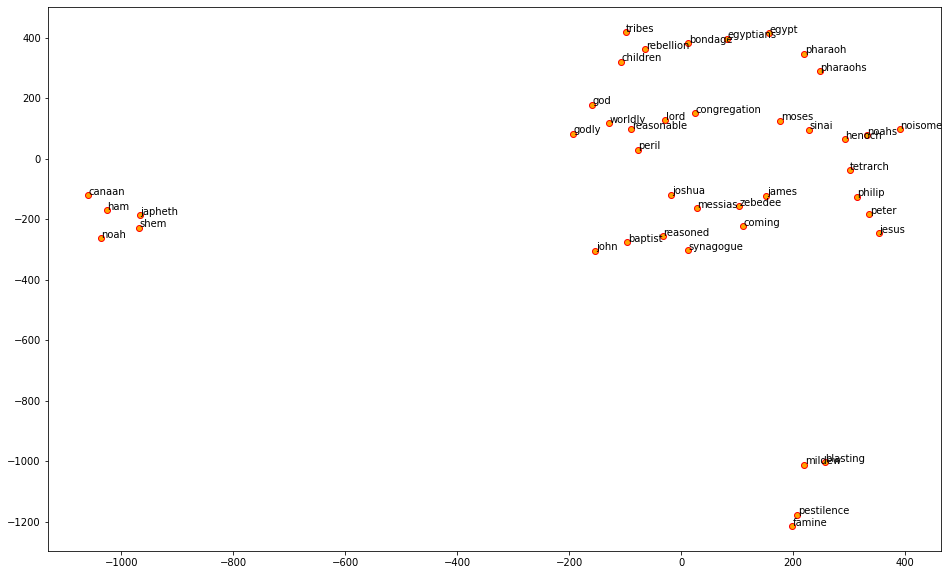

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])                                                # extract word labels, assign to words
wvs = w2v_model.wv[words]                                                                                   # save word vectors for each word

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)                                     # apply TSNE to reduce dimensionality to 2
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)                                                                                 # fit TSNE to word vectors
labels = words                                                                                              # assign words to labels

plt.figure(figsize=(16,10))                                                                                 # set figuresize
plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')                                                     # plot the 2 dimension word vectors using scatterplot
for label, x, y in zip(labels, T[:,0], T[:,1]):                                                             # apply word labels to data points
    plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

> **What words clustered together? Are any of the clusterings sensible?**

In the left corner I have jonah, japheth, and canaan, and ham (for example).
In the lower right quadrant the cluser has words like pestilence, and famine.

Then there is a large cluster with words like john, babtist, synogoge, jesus, peter, children etc.

I kind of felt like the clusters were dividing up information from the old testement and new testement. However, overall they still don't provide a full picture.



> #### **C) Applying Word2Vec Features to Document Clustering Task**

> **Let's bring in our toy corpus from Part 1 and apply the gensim word2vec model to produce word embeddings for our new vocab set.**

In [ ]:
corpus = ['The sky is blue 12 and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast, and beans.",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick'
]

labels = ['weather', 'weather', 'animal', 'food', 'food', 'animal', 'weather', 'animal']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category':labels})

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

In [ ]:
norm_corpus = [remove_punc(i) for i in norm_corpus]
norm_corpus

['sky blue beautiful  ',
 'love blue beautiful sky',
 'quick brown fox jumps lazy dog  ',
 'kings breakfast sausages ham bacon eggs toast beans  ',
 'love green eggs ham sausages bacon',
 'brown fox quick blue dog lazy',
 'sky blue sky beautiful today',
 'dog lazy brown fox quick']

In [ ]:
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]                                             # tokenize corpus

feature_size = 10                                                                                                   # set word2vec parameters
window_context = 10
min_word_count = 1
sample = 1e-3

In [ ]:
w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, window=window_context, min_count=min_word_count, sample=sample, iter=100) # fit word2vec to corpus

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


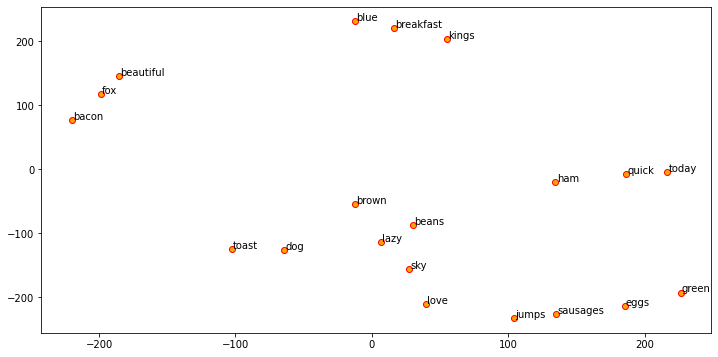

In [ ]:
from sklearn.manifold import TSNE
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(12,6))
plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:,0], T[:,1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')                                          # produce 2 dimensional scatterplot of word embeddings



**Which, if any, clusters of words make sense semantically? Which do not?**

I am really struggling to understand the cluster featuring, brown, lazy, sky, and love. Those words don't really seem to go together. Most of the other clusters don't make sense either.

The cluster that makes the most sense to me was jumps, eggs, and sausages because it did get two of the breakfast words in the same cluster.

**Now I create two functions to create average word vectors across all documents so that each word has an average vector value; then I create a average word vectorizer, so that each document has an average vector across all words in each document...**

In [ ]:
w2v_model.wv['sky']                                             # produce the weights for one word, "sky"

array([-0.03640855,  0.02315592,  0.00900635, -0.00063526, -0.02113269,
        0.00873214, -0.04456031, -0.01820652,  0.02672592,  0.02628203],
      dtype=float32)

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
  feature_vector = np.zeros((num_features,), dtype='float64')
  nwords= 0.

  for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = np.add(feature_vector, model[word])
  if nwords:
    feature_vector = np.divide(feature_vector, nwords)
  return feature_vector                                                                                                       # return average word vector


def average_word_vectorizer(corpus, model, num_features):
  vocabulary = set(model.wv.index2word)
  features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]     # return averge vector for each document in corpus
  return np.array(features)


w2v_feature_array = average_word_vectorizer(corpus = tokenized_corpus, model=w2v_model, num_features = feature_size)          # create array of document vectors
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9
0,0.005394,0.024377,0.031782,-0.002172,-0.020475,-0.002676,-0.010945,0.009199,-0.018197,0.025998
1,-0.006578,0.022964,0.030188,-0.012713,-0.027071,0.005714,-0.007638,0.004603,-0.011615,0.018878
2,0.003767,-0.006091,0.002187,-0.014005,-0.022865,0.018842,-0.006666,-0.023968,0.009473,0.015493
3,0.004051,0.013295,-0.006065,-0.004229,-0.004177,0.024805,-0.005918,-0.004070,-0.003818,0.006671
4,0.000518,-0.001131,-0.015839,-0.017874,-0.014705,0.012400,-0.019619,-0.001471,0.004712,-0.007774
5,0.010765,-0.002711,0.014587,-0.007424,-0.023042,0.021229,0.000398,-0.011971,0.000772,0.016099
6,-0.006542,0.013014,0.020076,-0.008324,-0.008044,0.009667,-0.011239,0.000214,-0.008504,0.011116
7,0.011447,-0.011965,0.008979,-0.007294,-0.018044,0.020721,-0.002189,-0.019028,0.008544,0.014045


**Why are there 8 rows? Why are there 10 columns and not the size of our vocab?**

We set our feature size to 10, so instead of having a feature for each vocab word, we have 10 averaged embedding values that represent the "meaning" of each document.

**Now let's use our document embeddings and perform a clustering analysis to examine how the documents are grouped. We will use `AffinityPropagation` from `sklearn` to produce our clusters; then we'll append the cluster label to our corpus dataframe.**

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_

cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Label'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,Cluster Label
0,The sky is blue 12 and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animal,2
3,"A king's breakfast has sausages, ham, bacon, e...",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animal,2
6,The sky is very blue and the sky is very beaut...,weather,0
7,The dog is lazy but the brown fox is quick,animal,2


**Do the cluster labels match up with the number/assignment of categories we completed last time?**

Yes.

**Finally, let's plot our document vectors to see where each of them fall within their clusters. We'll also utilize coloring based on cluster to make it a bit easier to read. We can reduce our document vectors down to 2 dimensions using a principal component analysis and scatterplot.**

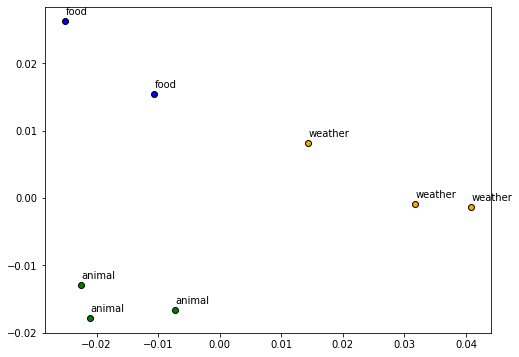

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)                                       # set parameters of PCA with 2 principle components
pcs = pca.fit_transform(w2v_feature_array)                                      # fit PCA to vector feature array to reduce dimensions
labels = ap.labels_                                                             # set cluster numbers to labels
categories = list(corpus_df['Category'])                                        # set corpus_df categories to categories
plt.figure(figsize=(8,6))                                                       # set figuresize

for i in range(len(labels)):
  label = labels[i]
  color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
  annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c=color, edgecolors='k')                                    # produce scatterplot of 2-dimensional document vectors, colored and labeled by category
  plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0,0), textcoords = 'offset points')

## **4) GloVe** Word Embeddings

**Word2Vec is one option for pretrained word embeddings, but GloVe serves as an alternative model that oftentimes has better results with easier implementation. Here we will apply GloVe Features from `spacy` for the same Machine Learning Task**

> #### **A) Apply Pretrained Word-Embeddings to Toy Corpus Vocab**

In [ ]:
!pip install spacy

try:
  spacy.load('en_core_web_lg')
except:
  !python -m spacy download en_core_web_lg                # 300 dimensional pretrained glove embeddings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 10.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')                        # load pretrained glove embedding model

In [ ]:
total_vectors = len(nlp.vocab.vectors)                    # find the length of the total number of vectors applied to the vocab
print('Total Word Vectors:', total_vectors)

Total Word Vectors: 514157


In [ ]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))        # produce vocab list from norm_corpus
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])                                      # apply word vectors to vocab from norm_corpus
pd.DataFrame(word_glove_vectors, index=unique_words)                                                            # produce df of glove vectors, indexed by words

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
brown,-3.84290,0.140680,-3.35840,3.267900,-2.15360,-6.508500,0.235120,6.884500,-0.543490,3.596900,...,-1.592000,1.02690,1.60640,-2.84040,-2.274700,2.10020,5.480200,0.83172,-4.30830,-1.04370
ham,0.44278,-4.114100,1.23560,4.187300,1.62440,-1.260100,-1.643500,-0.900330,-1.241500,0.867240,...,3.657400,-1.63910,3.90300,-6.56120,3.673700,-1.20580,3.819300,3.60500,3.63860,4.03620
lazy,-1.58880,0.733160,1.07460,-2.452100,-0.42517,3.334400,-0.179420,-1.092400,-0.093904,0.058663,...,1.125300,-2.35530,3.93600,-3.37510,-0.999340,1.26390,-2.106800,3.07430,-4.42900,3.89380
sky,7.15240,3.035600,-8.70400,0.937880,-3.67810,-0.035128,1.256800,0.024432,0.289240,4.505400,...,-5.771200,4.76440,4.23500,-1.84270,0.369470,1.31650,1.165000,-1.39280,-3.91250,0.48484
love,2.05650,-3.225900,-5.73640,-6.146000,0.15748,-2.428400,7.658000,2.706400,-2.211000,-0.899900,...,1.580200,1.75970,-0.60806,-6.61070,0.009383,-4.27630,-0.505070,5.00490,-8.53120,-1.49670
blue,-4.31020,2.570600,-3.47220,2.520500,-1.11040,-5.101400,-1.481200,4.655900,0.383650,2.477200,...,-5.250500,4.20530,2.92490,-0.93310,0.890710,6.85240,0.075678,1.07370,-2.96000,-0.42209
sausages,-0.95324,-3.505800,-1.52990,2.149900,3.81270,-1.850400,-0.960970,1.255800,-2.262700,1.484200,...,3.824700,-0.62691,2.76300,-5.66990,-0.950370,-0.58964,2.101200,1.12920,0.98625,0.59990
eggs,0.94699,-3.802500,-5.22820,1.638600,4.74710,-3.459600,-2.239200,0.847490,-3.645700,3.273800,...,6.575500,1.13930,-2.46300,-7.98480,-7.093400,-2.87130,3.126500,3.40870,-4.73420,-0.91956
breakfast,-0.68660,-1.726700,-3.00130,-1.110100,1.83890,-3.076600,-0.233690,1.013300,-2.023400,3.033700,...,1.173600,-2.72720,1.57230,-2.42900,-1.527600,0.98387,-0.098775,2.95160,-1.60790,2.54120
today,1.53330,1.622600,1.05520,-1.361500,0.97952,-0.828060,1.485400,2.881700,-0.354000,0.344570,...,3.243400,-1.53780,2.36610,-2.51120,-1.267200,-1.48080,-1.282500,1.41430,-2.50450,2.77440


> #### **B) Use TSNE to visualize the glove embeddings in a lower-dimensional scatter plot.**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


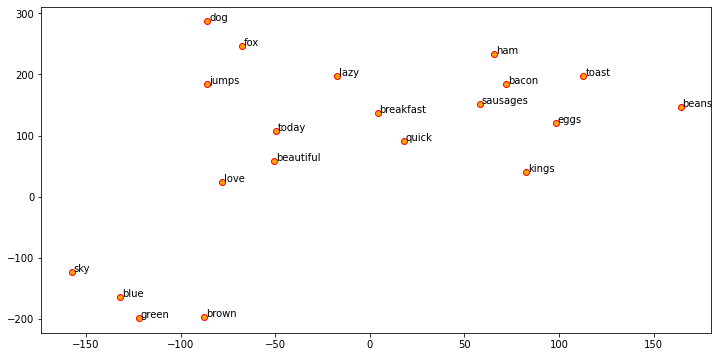

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12,6))
plt.scatter(T[:,0], T[:,1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:,1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

**How does this scatteplot compare to that produced from word2vec embeddings?**

The words grouped together make more sense, however, there are less definitive clusters with the Glove model,

> #### **C) Use Kmeans clustering to cluster documents based on word embeddings**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters = 3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_

cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Label'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,Cluster Label
0,The sky is blue 12 and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animal,2
3,"A king's breakfast has sausages, ham, bacon, e...",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animal,2
6,The sky is very blue and the sky is very beaut...,weather,1
7,The dog is lazy but the brown fox is quick,animal,2


> #### **D) Use PCA to Produce Scatterplot of Document Clusters**

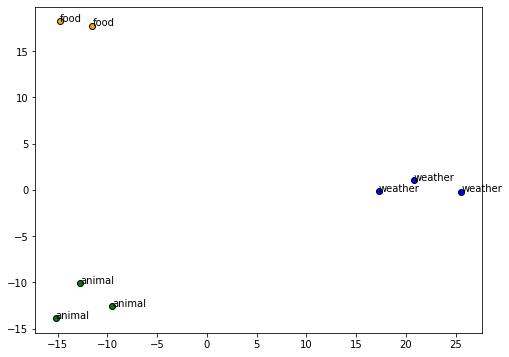

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(doc_glove_vectors)
labels = km.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8,6))

for i in range(len(labels)):
  label = labels[i]
  color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
  annotation_label = categories[i]
  x, y = pcs[i]
  plt.scatter(x, y, c=color, edgecolors='k')
  plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0,0), textcoords = 'offset points')

**How are the document embeddings different based on GloVe as compared to Word2Vec, based on this two dimensional representation of the document clusters?**

They are the same.